In [1]:
# Time each cell
%load_ext autotime

In [2]:
import os
import threading
import time

from matplotlib import pyplot as plt
%matplotlib inline

import h5py
import pandas as pd
from glob import glob

from IPython.display import Image, display
import ipywidgets as widgets

import numpy as np
from astropy.io import fits
from astropy.nddata.utils import Cutout2D, PartialOverlapError, NoOverlapError
from astropy.stats import sigma_clipped_stats
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.time import Time
from astropy.utils.console import ProgressBar

from matplotlib.ticker import FormatStrFormatter
from copy import copy

from piaa.utils import helpers
from piaa.utils import images as img_utils
from piaa import exoplanets
from piaa.observation import Observation
from piaa.utils import pipeline
from pocs.utils.images import fits as fits_utils

palette = copy(plt.cm.inferno)
palette.set_over('w', 1.0)
palette.set_under('k', 1.0)
palette.set_bad('g', 1.0)

/home/wtylergee/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/wtylergee/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


time: 2.1 s


In [3]:
os.environ['PGPASSWORD'] = 'pan0pt3&-t3ss'
data_dir = '/var/panoptes/images/fields'

time: 1.18 ms


In [4]:
# sequence = 'PAN001/Wasp80/14d3bd/20180609T095151'
# sequence = 'PAN001/Hd189733/14d3bd/20180614T093015'
sequence = 'PAN001/Hd189733/14d3bd/20180807T071517'

time: 864 µs


In [5]:
stamp_size = (14, 14)

time: 1.28 ms


In [6]:
# Download FITS files
fits_blobs = helpers.get_observation_blobs(sequence)
len(fits_blobs)

53

time: 657 ms


In [7]:
# Download all the FITS files from a bucket
fits_files = list()
if fits_blobs:
    with ProgressBar(len(fits_blobs), 'Downloading FITS files'.ljust(25)) as bar:
        for i, blob in enumerate(fits_blobs):
            fits_fn = helpers.unpack_blob(blob, save_dir=data_dir)
            fits_files.append(fits_fn)
            bar.update(i)

fits_files = fits_files
num_frames = len(fits_files)

FloatProgress(value=0.0)


time: 78.1 ms


In [8]:
# Plate-solve all the images - safe to run again
solved_files = list()
with ProgressBar(
        len(fits_files), 
        'Solving files'.ljust(25)) as bar:
    for i, fn in enumerate(fits_files):
        try:
            fits_utils.get_solve_field(fn, timeout=90)
            solved_files.append(fn)
        except Exception:
            print("Can't solve file {}".format(fn))
            continue

solved_files = solved_files

FloatProgress(value=0.0)


time: 1.24 s


In [9]:
len(solved_files)

53

time: 3.83 ms


In [10]:
wcs = WCS(solved_files[0])

time: 25.2 ms


In [11]:
# Lookup point sources
# You need to set the env variable for the password for TESS catalog DB (ask Wilfred)
# os.environ['PGPASSWORD'] = 'sup3rs3cr3t'
point_sources = pipeline.lookup_point_sources(
    solved_files, 
    wcs=wcs, 
    force_new=True
)

time: 21.4 s


In [12]:
len(point_sources)

75813

time: 3.16 ms


In [13]:
point_sources.head()

,x,y,ra,dec,background,flux_auto,flux_max,fluxerr_auto,fwhm,flags,snr,twomass,tmag,vmag,d2d
id,,,,,,,,,,,,,,,
51395598,4577.5083,61.5508,305.161275,17.017465,2072.530,467.9012,74.64262,99.91589,0.22,0,4.682951,20203945+1700374,11.633,13.128,0.007669
435949079,681.5363,64.0000,305.581253,28.092177,2069.593,351.4149,61.48784,81.72353,2.35,0,4.300046,20222028+2804493,11.744,13.483,0.012167
99223850,1202.3519,62.6867,305.524187,26.617198,2073.237,251.5067,62.89775,74.89093,1.98,0,3.358307,20220671+2637121,11.708,13.316,0.004373
402764877,2755.9780,60.3190,305.356504,22.193450,2076.048,726.5176,101.94640,116.50610,2.14,0,6.235876,20212605+2211313,11.744,12.979,0.002369
51396993,4413.9731,60.1588,305.182025,17.479586,2072.446,772.9290,60.96803,136.59040,3.29,0,5.658736,20204178+1728450,12.738,13.979,0.007587


time: 34.5 ms


In [14]:
arcsecs = (point_sources.d2d.values * u.degree).to(u.arcsec)

time: 1.67 ms


Text(0,0.5,'Δ arcsec')

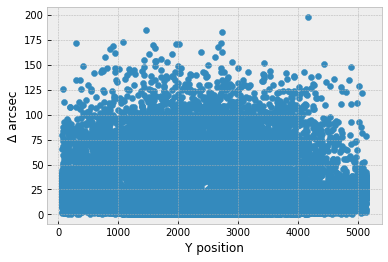

time: 996 ms


In [15]:
plt.scatter(point_sources.x.values, arcsecs)
plt.xlabel('Y position')
plt.ylabel('Δ arcsec')

In [16]:
arcsec_bins = np.histogram(arcsecs, bins=np.linspace(0, 30, 20))

time: 7.38 ms


Text(0.5,1.05,'Tess Catalog Offset')

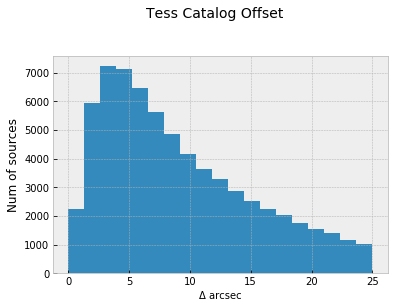

time: 344 ms


In [17]:
pixel_scale = 10.3

fig, ax1 = plt.subplots()

ax1.hist(arcsecs, bins=np.linspace(0, 25, 20))

# ax2 = ax1.twiny()
s2 = arcsec_bins[1] / pixel_scale

ax1_ticks = ax1.get_xticks()
# ax2_scale = ax1_ticks / pixel_scale

# ax2.set_xlabel("Δ pixels", fontsize=10)
# ax2.set_xticks(ax2_scale)
# ax2.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax2.grid(color='r', linestyle='--', alpha=0.25, linewidth=2)

ax1.set_xlabel("Δ arcsec", fontsize=10)
ax1.set_ylabel("Num of sources")

fig.suptitle('Tess Catalog Offset', y=1.05, fontsize=14)
# fig.tight_layout()

Text(0.5,1,'SNR')

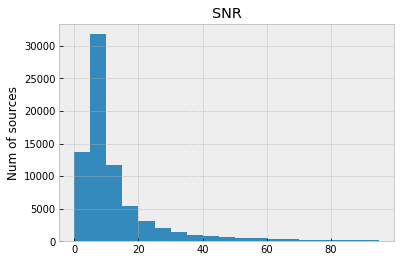

time: 265 ms


In [18]:
point_sources.snr.hist(bins=np.arange(0,100, 5))
plt.ylabel('Num of sources')
plt.title('SNR')

Text(0.5,1,'Vmags')

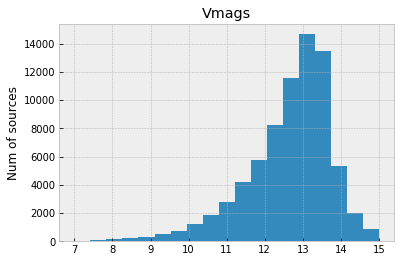

time: 262 ms


In [19]:
point_sources.vmag.hist(bins=np.linspace(7, 15, 20))
plt.ylabel('Num of sources')
plt.title('Vmags')

In [20]:
from astropy import units as u
from astropy.nddata import CCDData
from ccdproc import Combiner
from ccdproc import wcs_project

time: 21.9 ms


In [21]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 300.177760408  22.7116519374  
CRPIX : 2604.5  1738.5  
CD1_1 CD1_2  : -1.63435136917e-06  -0.00286366151555  
CD2_1 CD2_2  : -0.00286323323833  1.43308101192e-06  
NAXIS : 5208  3476

time: 5.47 ms


In [22]:
ccd = CCDData.read(solved_files[0], unit='adu')

time: 70.8 ms


In [31]:
center_x = 2604.5
center_y = 1738.5

time: 974 µs


In [87]:
cutout_position = (center_x - 5, center_y + 85)

time: 1.05 ms


In [88]:
d0 = Cutout2D(ccd, cutout_position, 200, wcs=ccd.wcs)

time: 26.3 ms


In [83]:
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize)

time: 1.04 ms


In [89]:
c0 = d0.data

time: 2.36 ms


In [90]:
norm = ImageNormalize(c0, interval=MinMaxInterval(),
                      stretch=SqrtStretch())

time: 1.78 ms


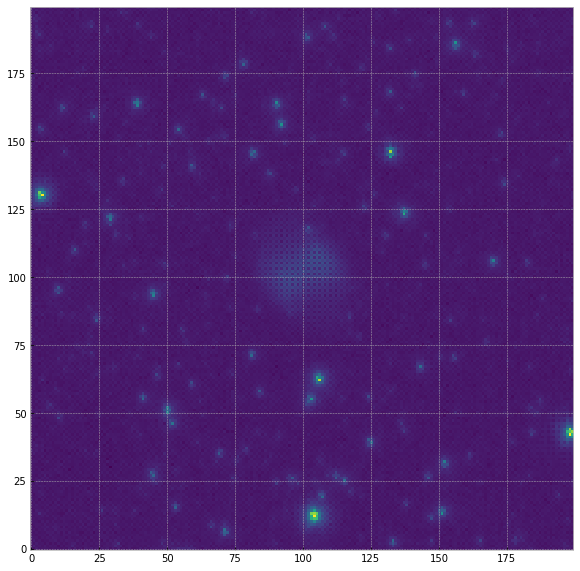

time: 463 ms


In [93]:
plt.figure(figsize=(10, 10))
plt.imshow(c0, norm=norm)

In [132]:
cutout_size = 100

time: 894 µs


In [133]:
target_wcs = None
reprojected = []
for fits_fn in ProgressBar(solved_files, ipython_widget=True):
    ccd0 = CCDData.read(fits_fn, unit='adu')
    d0 = Cutout2D(ccd.data, cutout_position, cutout_size, wcs=ccd.wcs)
    
    if target_wcs is None:
        target_wcs = d0.wcs
    
    ccd1 = CCDData(d0.data, wcs=d0.wcs, unit='adu')
    new_image = wcs_project(ccd1, target_wcs)
    reprojected.append(new_image)

FloatProgress(value=0.0)


time: 5.41 s


In [134]:
combiner = Combiner(reprojected)
stacked_image = combiner.average_combine()

time: 18 ms


In [135]:
stacked_image.wcs = target_wcs

time: 948 µs


In [139]:
stacked_image.write('/var/panoptes/dumbbell.fits', overwrite=True)

time: 19.5 ms


In [137]:
from astropy.visualization import simple_norm

time: 970 µs


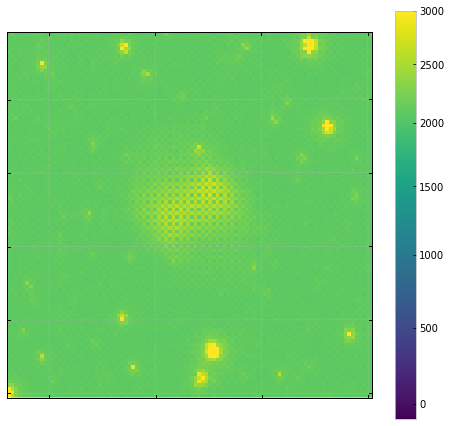

time: 560 ms


In [140]:
fig = plt.figure(figsize=(18,7.5))

asinh_norm = simple_norm(stacked_image, stretch='asinh', min_cut=-100, max_cut=3000, asinh_a=0.9)
ax1 = plt.subplot(1, 2, 1, projection=target_wcs)
im_asinh = ax1.imshow(stacked_image, cmap='viridis', norm=asinh_norm)
ax1.coords[0].set_axislabel('Right Ascension')
ax1.coords[0].set_major_formatter('hh:mm:ss')
ax1.coords[1].set_axislabel('declination')
ax1.coords[1].set_major_formatter('dd:mm:ss')
ax1.grid()
# ax1.set_title("Huntsman Telescope - NGC 6744 - $g'$ - arcsinh stretch")
fig.colorbar(im_asinh, ax=ax1)

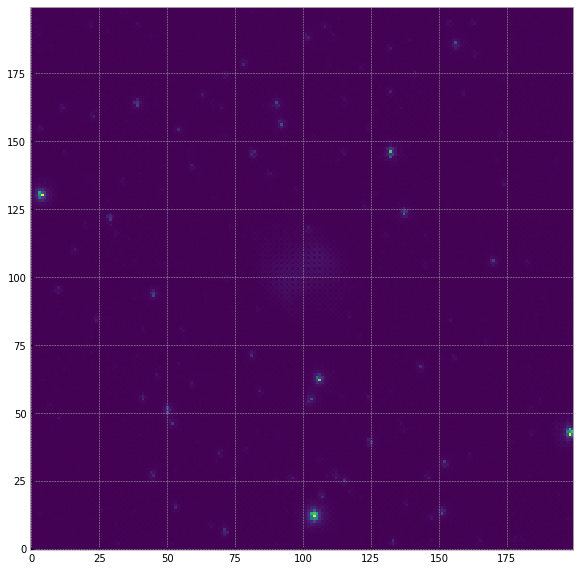

time: 481 ms


In [113]:
plt.figure(figsize=(10, 10))
plt.imshow(stacked_image, 
           norm=ImageNormalize(stacked_image, interval=MinMaxInterval(), stretch=SqrtStretch()))
plt.imshow(stacked_image)

In [ ]:
snr_limit = 10

In [ ]:
# Create stamps
stamps_fn = pipeline.create_stamp_slices(
    sequence,
    solved_files,
    point_sources[point_sources.snr >= snr_limit],
    stamp_size=stamp_size
)

In [ ]:
stamps_fn

In [ ]:
# stamps_fn = '/var/panoptes/psc/PAN001_Wasp80_14d3bd_20180609T095151.hdf5'
# stamps_fn = '/var/panoptes/psc/PAN001_Hd189733_14d3bd_20180614T093015.hdf5'
sequence = 'PAN001_Tres3_14d3bd_20180624T063045.hdf5'
stamps_fn = '/var/panoptes/psc/' + sequence

In [4]:
stamps = h5py.File(stamps_fn)

time: 3.42 ms


In [5]:
len(stamps)

5775

time: 14 ms


In [6]:
# picid = '243921117' # Wasp 80
# picid = '256364928'
# picid = '243952829'
# picid = '248311256'
picid = '116264089' # Tres-3

time: 527 ms


In [40]:
picid = list(stamps.keys())[np.random.randint(0, len(stamps))]

time: 27 ms


In [41]:
picid in stamps

True

time: 6.77 ms


In [42]:
vary_series = pipeline.find_similar_stars(
    picid, 
    stamps,
    out_fn='/var/panoptes/psc/similar_{}_{}.csv'.format(sequence.replace('/','_'), picid)
)

time: 12.9 s


In [43]:
vary_series.head()

,v
289163854,0.000000
288643170,0.112559
289164764,0.112905
383720378,0.133991
157542346,0.135256


time: 9.85 ms


In [44]:
num_refs = 100
camera_bias = 2048
stamp_size = (14, 14)

time: 1.81 ms


In [45]:
stamp_collection = np.array([pipeline.get_psc(str(idx), stamps) - camera_bias 
                           for idx in vary_series.index[:num_refs]])
print("Stamp collection shape: {}".format(stamp_collection.shape))

Stamp collection shape: (100, 60, 196)
time: 83.3 ms


In [46]:
normalized_collection = np.array([pipeline.normalize(s) for s in stamp_collection])

time: 54.4 ms


In [47]:
coeffs = pipeline.get_ideal_full_coeffs(normalized_collection)

time: 166 ms


In [48]:
num_frames = np.array(stamps[picid]['data']).shape[0]

time: 5.43 ms


In [49]:
ideal = pipeline.get_ideal_full_psc(
    stamp_collection, 
    coeffs[0]
).reshape(num_frames, -1)

time: 11.1 ms


In [50]:
target = stamp_collection[0].reshape(num_frames, -1)

time: 2.48 ms


In [51]:
target.shape

(60, 196)

time: 8.08 ms


In [52]:
lc = (target.sum(1) / ideal.sum(1))

time: 3.59 ms


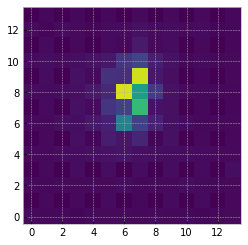

time: 8.55 s


In [53]:
ani = helpers.animate_stamp(target.reshape(num_frames, stamp_size[0], stamp_size[1]))
ani

In [54]:
image_times = np.array(stamps.attrs['image_times'])

time: 3.92 ms


In [55]:
image_times = [Time(t0, format='mjd').to_datetime() for t0 in image_times]

time: 45.2 ms


In [56]:
lc0 = pd.DataFrame(lc, index=image_times, columns=['rel_flux'])

time: 6.25 ms


In [57]:
lc0.head()

,rel_flux
2018-06-24 06:26:46,0.905323
2018-06-24 06:29:44,0.903646
2018-06-24 06:32:40,0.908905
2018-06-24 06:35:36,0.902604
2018-06-24 06:38:33,0.891678


time: 12.9 ms


In [58]:
target.shape

(60, 196)

time: 4.66 ms


Text(0.5,1,'Relative flux')

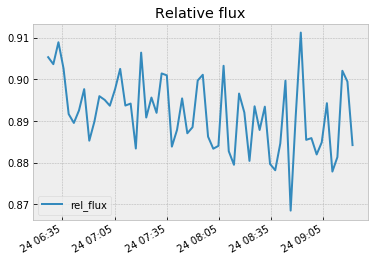

time: 402 ms


In [59]:
lc0.plot()
plt.title('Relative flux')

In [60]:
lc0.std()

rel_flux    0.008805
dtype: float64

time: 7.44 ms


In [ ]:
aperture_size = 4

diff = list()
for picid in ProgressBar(list(stamps.keys())):
    try:
        psc = pipeline.get_psc(str(picid), stamps) - camera_bias
    except ValueError:
        continue
    
    if float(stamps[picid].attrs['vmag']) > 13:
        continue

    try:
        rgb_stamp_masks = helpers.get_rgb_masks(
            psc[0].reshape(stamp_size[0], stamp_size[1]), 
            force_new=True
        )
    except ValueError:
        continue
    
    for frame_idx in range(psc.shape[0]):
        d0 = psc[frame_idx].reshape(stamp_size[0], stamp_size[1])

        star_pos_x = np.array(stamps[picid]['original_position'])[frame_idx][0]
        star_pos_y = np.array(stamps[picid]['original_position'])[frame_idx][1]
        slice0 = helpers.get_stamp_slice(star_pos_x, star_pos_y, stamp_size=stamp_size)

        try:
            y_pos, x_pos = np.argwhere(d0 == d0.max())[0]
            aperture_position = (x_pos, y_pos)
        except IndexError:
            print("No star position: ", frame_idx, slice0, star_pos_x, star_pos_y)
            continue

        color_flux = dict()
        for color, mask in zip('rgb', rgb_stamp_masks):

            d1 = np.ma.array(d0, mask=~mask)

            try:
                d2 = Cutout2D(d1, aperture_position, aperture_size, mode='strict')
            except (PartialOverlapError, NoOverlapError) as e:
                continue
            except Exception as e:
                continue

            diff.append({
                'picid': picid,                
#                 'obstime': observation.stamps['image_times'][frame_idx],
                'color': color,
                'value': d2.data.sum(),
            })

In [ ]:
len(diff)

In [ ]:
diff

In [ ]:
try:
    lc = pd.DataFrame(diff).set_index('obstime')          

    csv_file = '/var/panoptes/images/lc/{}_diff.csv'.format(sequence.replace('/', '_'))
    print("Writing csv to {}".format(csv_file))
    lc.to_csv(csv_file)
except Exception as e:
    print("Problem creating CSV file: {}".format(e))        

In [ ]:
lc = pd.read_csv('/var/panoptes/images/lc/{}_diff.csv'.format(sequence.replace('/', '_'))).set_index(['picid', 'obstime'])

In [ ]:
lc.head()

In [ ]:
foo = lc.groupby(by=['picid', 'color']).describe()

In [ ]:
foo.to_csv('/var/panoptes/g_stats_{}_desc.csv'.format(sequence.replace('/', '_')))

In [ ]:
picid_list = lc.picid.unique()

stats = list()
for picid in tqdm_notebook(picid_list):
    rows = lc.picid == picid
    color = lc.color == 'g'

    l0 = lc[rows & color]
    
    count_mean, count_median, count_std = sigma_clipped_stats(l0.value)
    
    mag = -2.5 * np.log10(l0.value / 120)

    mag_mean, mag_median, mag_std = sigma_clipped_stats(mag)
    
#     std = (l0.value - l0.value.mean()).std()
#     avg_std = (std / l0.value).mean()

    # Get the vmag
    vmag = observation.stamps[str(picid)].attrs['vmag']
    
    stats.append([vmag, count_mean, count_median, count_std, mag_mean, mag_median, mag_std])

In [ ]:
g_stats = pd.DataFrame(noise, columns=['vmag','count_mean', 'count_median', 'count_std', 'mag_mean', 'mag_median', 'mag_std'], index=picid_list)

In [ ]:
g_stats.to_csv('/var/panoptes/g_stats_{}.csv'.format(sequence))

In [ ]:
plt.style.use('bmh')

In [ ]:
mags = g_stats.vmag
stds = g_stats.mag_std

In [ ]:
plt.figure(figsize=(12,9))
plt.scatter(mags, stds, alpha=0.25)
plt.xlim([6,14])
plt.ylim([0, .2])
plt.xlabel('V mag')
plt.ylabel('Standard dev. (mag.)')

In [ ]:
lc.groupby(by='picid').vmag.hist(bins=np.arange(6,17))

In [ ]:
lc.vmag.hist(bins=np.arange(6,17))